# Trendvorhersage Metadaten

Die Vorhersage von Trends ist aus unterschiedlichen Gründen sehr interessant und wird schon seit sehr, sehr langer Zeit analysiert. 

Dafür kommen sowohl statistische Methoden als auch (modernere) Methoden des Maschinellen Lernens in Frage. Du wirst dir in diesem Teil beides anschauen und sowohl Trends in den Metadaten als auch in den Textbeiträgen selbst analysieren.

Zuerst betrachtest du Trends in Metadaten.

## Nutzung für die Reddit-Daten

Im Technology-Subreddit bzw. in dem daraus abgeleiteten Transport-Bereich gibt es verschiedene Metriken, die du betrachten kannst. Lade zuerst wie gewohnt die Daten in einen `DataFrame`.

In [1]:
import pandas as pd

posts = pd.read_csv("transport-all-comments.csv.xz", parse_dates=["created_utc"])

# damit du leichter addieren kannst
posts["count"] = 1

Um die Posts pro Tag auszurechnen, summierst du das einfach auf:

In [3]:
posts_day = posts.set_index("created_utc").resample("D").sum()
posts_day

/tmp/ipykernel_2321096/521439133.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  posts_day = posts.set_index("created_utc").resample("D").sum()


,score,count
created_utc,,
2008-01-25,1,1
2008-01-26,0,0
2008-01-27,0,0
2008-01-28,0,0
2008-01-29,0,0
...,...,...
2022-09-03,4975,496
2022-09-04,4610,948
2022-09-05,4123,139


Schau dir die dazugehörige Grafik an:

<Axes: xlabel='created_utc'>

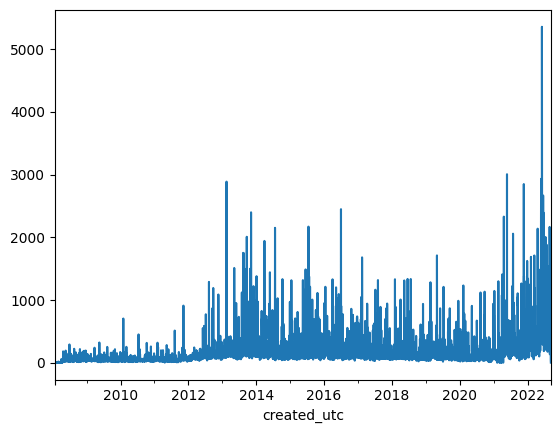

In [4]:
posts_day["count"].plot.line()

Hier zeigt sich schon eine interessante Herausforderung: die Daten *fluktuieren*. Vermutlich ist der Grund eine Schwankung über die unterschiedlichen Wochentage. Das wirst du später noch genauer untersuchen, fürs Erste möchtest du die Anzahl der Posts auf Monatsbasis aggregrieren. Zum Glück geht das mit `pandas` ganz einfach:

/tmp/ipykernel_2321096/310204232.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  posts_month = posts.set_index("created_utc").resample("M").sum()


<Axes: xlabel='created_utc'>

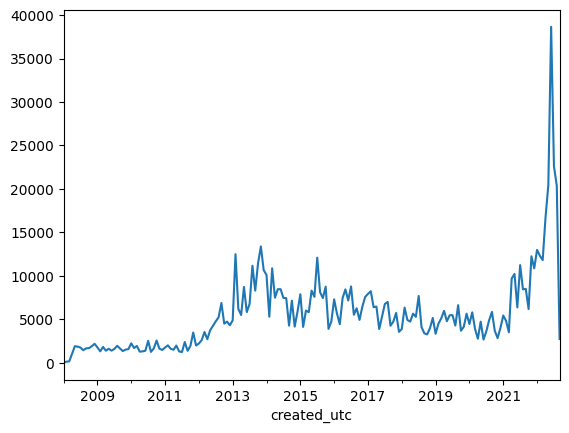

In [11]:
posts_month = posts.set_index("created_utc").resample("M").sum()
posts_month["count"].plot()

Die Wahl der richtigen Datengranularität hat ganz erheblichen Einfluss auf die Trendvorhersage! Du hast die Daten nun stark geglättet und kannst langfristige Trends gut vorhersagen, die Unterschiede in den Wochentagen hast du damit aber *verwischt*. Sog. *Saisonalitäten* in den Jahreszeiten wären hingegen noch enthalten.

Versuche nun, hierfür die lineare Regression auszurechnen:

In [12]:
from scipy.stats import linregress
lr = linregress(range(len(posts_month)), posts_month["count"].values)
lr

LinregressResult(slope=47.2902672218279, intercept=1364.4677839141732, rvalue=0.5361294615084039, pvalue=1.4682456232429715e-14, stderr=5.628535049941061, intercept_stderr=572.747808695533)

Zeichne die Daten ein, am besten geht das direkt als Vorhersage im `DataFrame`:

<Axes: xlabel='created_utc'>

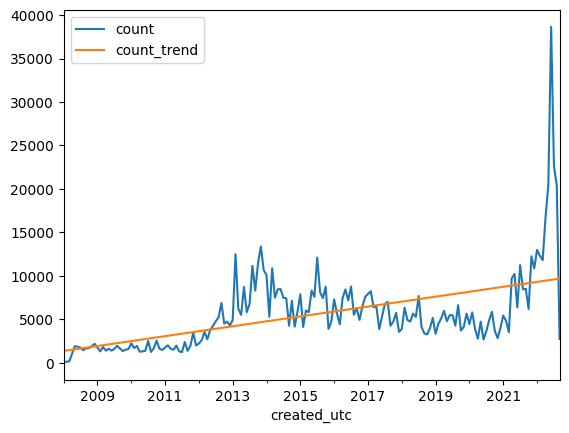

In [13]:
import numpy as np
posts_month["count_trend"] = lr.intercept + lr.slope*np.arange(len(posts_month))
posts_month[["count", "count_trend"]].plot.line()

Das Ergebnis ist als Langzeittrend interpretierbar. Allerdings könnte der Anstieg auf auch die enorm große Postmenge Mitte 2022 zurückzuführen sein.

Für solch komplexe Szenarien gibt es noch bessere Verfahren. Damit könnte man z.B. auch Perioden etc. vorhersagen.

## Vorhersage mit Machine Learning

Du kannst auch kompliziertere Techniken des Maschinellen Lernens zur Trendvorhersage nutzen. Häufig wird dazu ein sog. [LSTM](https://de.wikipedia.org/wiki/Long_short-term_memory) verwendet, allerdings ist das ziemlich kompliziert und erfordert auch lange Rechenzeiten. Es muss auch einfacher gehen!

## Vorhersage mit `prophet`

[`prophet`](https://facebook.github.io/prophet/) ist ein Softwarepaket von Facebook, das auf die Trendvorhersage spezialisiert ist. Es ist sehr einfach bedienbar und nutzt fortgeschrittene Methoden zur Vorhersage.

`prophet` produziert zwar nicht immer die besten Resultate, aber man muss sich schon sehr anstrengen und ganz spezielle Software verwenden, um es im Einzelfall zu schlagen.

Deswegen betrachtest du nun `prophet` genauer und wendest es auf unterschiedliche Szenarien an.

In [14]:
from prophet import Prophet

`prophet` erfordert einen `DataFrame`, der aus den beiden Spalten `ds` und `y` besteht:

In [15]:
df = pd.DataFrame({"ds": posts_month.index.values, 
                   "y": posts_month["count"].values})
df

,ds,y
0,2008-01-31,1
1,2008-02-29,128
2,2008-03-31,163
3,2008-04-30,1050
4,2008-05-31,1911
...,...,...
172,2022-05-31,20443
173,2022-06-30,38651
174,2022-07-31,22614
175,2022-08-31,20368


Zuerst muss du ein `Prophet`-Objekt instanziieren, um anschließend die `fit()`-Methode aufrufen zu können.

In [16]:
m = Prophet()
m.fit(df)

16:37:24 - cmdstanpy - INFO - Chain [1] start processing
16:37:24 - cmdstanpy - INFO - Chain [1] done processing


Anschließend kannst du einen neuen `DataFrame` erzeugen, der die Zeitpunkte für die Vorhersage enthält. Du möchtest die Vorhersage auf Monatsbasis durchführen:

In [17]:
future = m.make_future_dataframe(periods=24, freq='M')
future

,ds
0,2008-01-31
1,2008-02-29
2,2008-03-31
3,2008-04-30
4,2008-05-31
...,...
196,2024-05-31
197,2024-06-30
198,2024-07-31
199,2024-08-31


... und schließlich auch berechnen:

In [18]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
196,2024-05-31,12314.904760,7386.028893,17032.035366
197,2024-06-30,12738.133720,8036.550243,17713.832250
198,2024-07-31,12923.537186,8341.753875,17656.919313
199,2024-08-31,12282.683294,7582.712577,16766.952413
200,2024-09-30,10860.784978,6060.363311,15738.994264


Eine Stärke von `prophet` sind auch die integrierten Funktionen zur Visualisierung:

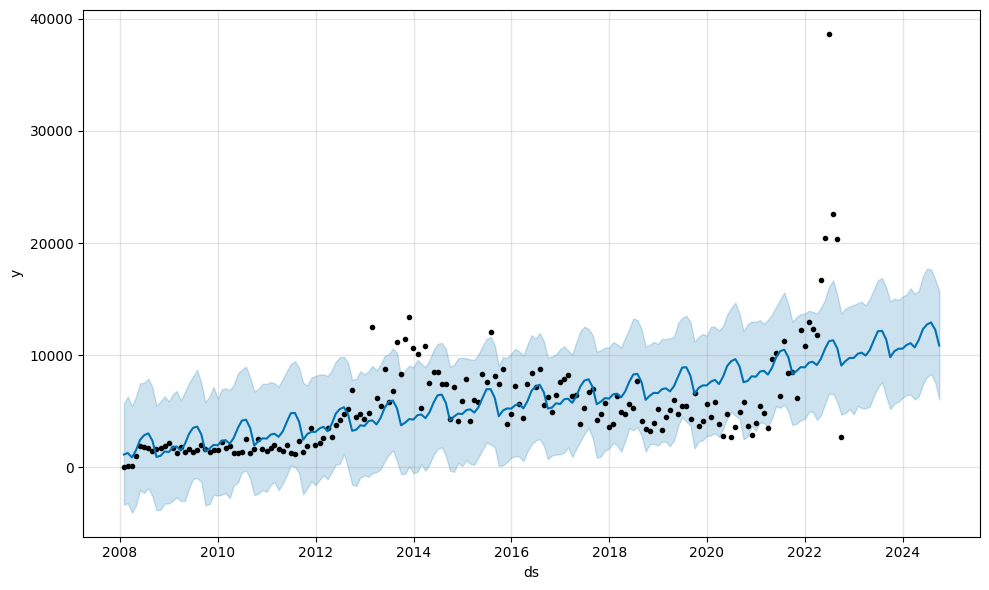

In [19]:
fig1 = m.plot(forecast)

Das Ergebnis sieht schon sehr gut aus, viele Punkte befinden sich innerhalb des *Konfidenzkorridors*. Die Ausrutscher hat `prophet` als solche behandelt und ignoriert.

Spannend sind auch die Komponenten der Vorhersage, die nur den Trend und die Saisonalität darstellen:

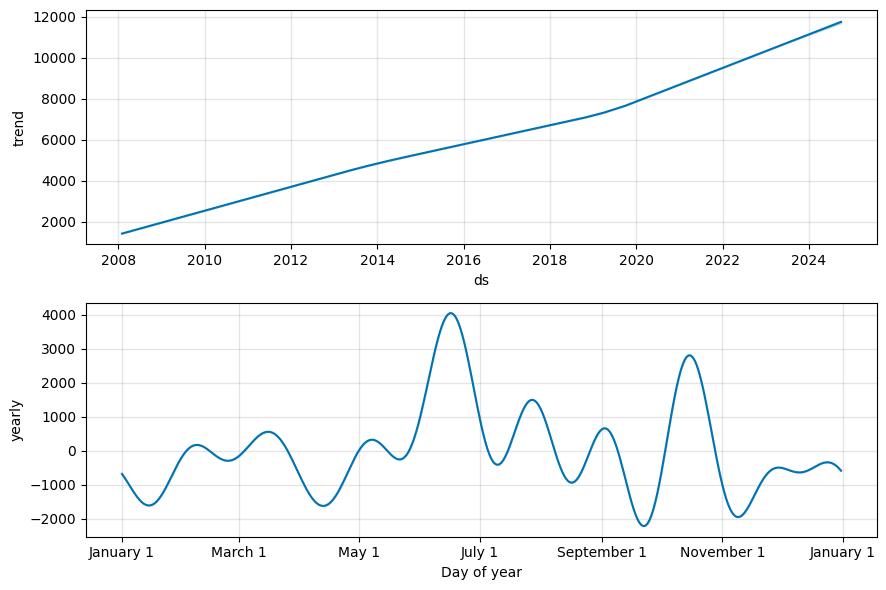

In [20]:
fig2 = m.plot_components(forecast)

## Unterschiedliche Wochentage 

Nun kannst du dich fragen, ob die Verteilung der Posts über die Wochentage auch unterschiedlich ist. Dazu musst du zurückgehen auf die noch nicht aggregierten Daten. Der Rest ist fast identisch zu dem oberen Verfahren:

In [21]:
df = pd.DataFrame({"ds": posts_day.index, "y": posts_day["count"]})

In [22]:
m = Prophet(daily_seasonality=True)
m.fit(df)

16:37:29 - cmdstanpy - INFO - Chain [1] start processing
16:37:30 - cmdstanpy - INFO - Chain [1] done processing


*fast*... Hier wird der Future-`DataFrame` auf Tagesbasis erzeugt für zwei Jahre (Schaltjahr!) in die Zukunft:

In [23]:
future = m.make_future_dataframe(periods=731, freq='D')
future

,ds
0,2008-01-25
1,2008-01-26
2,2008-01-27
3,2008-01-28
4,2008-01-29
...,...
6066,2024-09-03
6067,2024-09-04
6068,2024-09-05
6069,2024-09-06


In [24]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
6066,2024-09-03,879.669146,576.768761,1209.662290
6067,2024-09-04,874.766945,544.596306,1199.249807
6068,2024-09-05,870.648002,580.273335,1192.372795
6069,2024-09-06,879.721802,555.101322,1185.332748
6070,2024-09-07,841.469527,535.993798,1166.164261


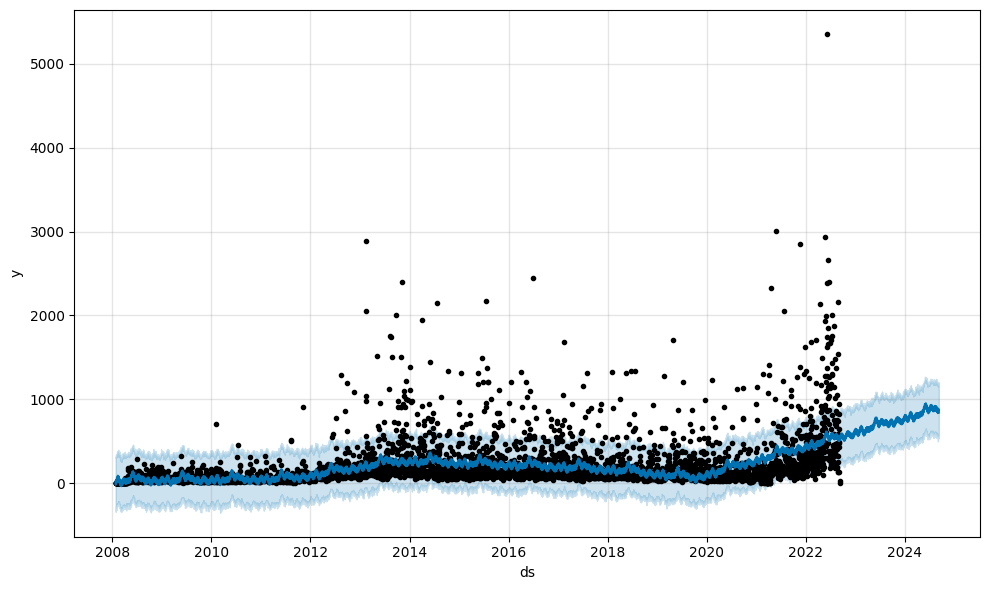

In [25]:
fig1 = m.plot(forecast)

Das *Geflimmere* wird schon ziemlich gut abgebildet.

Betrachte nun die Komponenten:

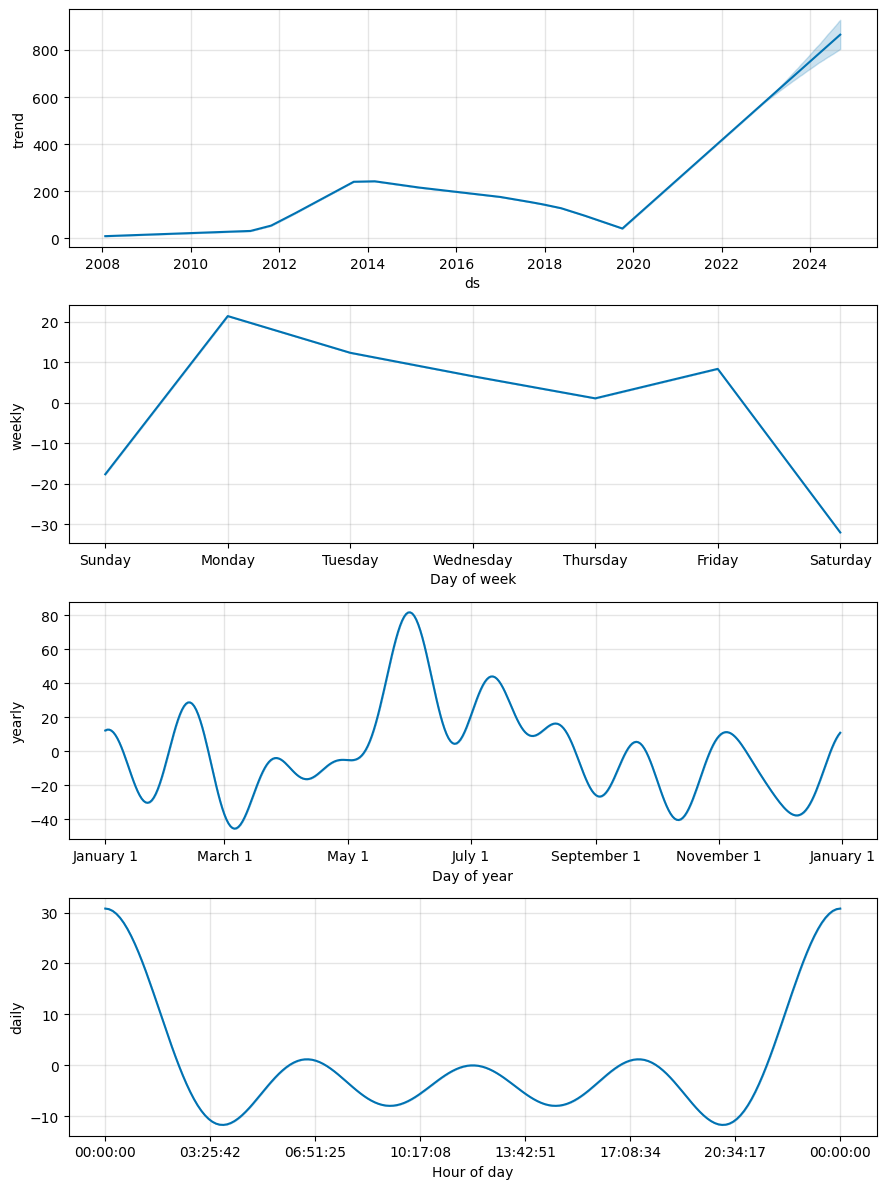

In [26]:
fig2 = m.plot_components(forecast)

Offenbar wird der Transport-Flair des  Technology-Reddit im Juni mehr verwendet als im Dezember. Samstag und Sonntag sind Tage mit ziemlich geringer Nutzung.